In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../training_data/train_transformed.csv")
test_df = pd.read_csv("../training_data/test_transformed.csv")

In [3]:
X, y = df.drop('revenue', axis=1), df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=118)

## Ridge and Lasso Regression

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [5]:
# Définir le pipeline : scaler suivi d’un modèle Ridge
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Grille de paramètres : attention à préfixer avec 'ridge__'
params_ridge = {
    'ridge__alpha': [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'ridge__fit_intercept': [True, False],
    'ridge__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# GridSearchCV avec pipeline
ridge_regressor = GridSearchCV(ridge_pipeline, params_ridge, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(X_train, y_train)

# Affichage des meilleurs paramètres et score
print(f'Optimal alpha: {ridge_regressor.best_params_["ridge__alpha"]:.2f}')
print(f'Optimal fit_intercept: {ridge_regressor.best_params_["ridge__fit_intercept"]}')
print(f'Optimal solver: {ridge_regressor.best_params_["ridge__solver"]}')
print(f'Best score: {ridge_regressor.best_score_:.4f}')

Optimal alpha: 20.00
Optimal fit_intercept: True
Optimal solver: sparse_cg
Best score: -0.4695


In [6]:
from sklearn.metrics import r2_score, mean_squared_error
# Prédictions avec le pipeline entraîné (inclut la normalisation)
y_train_pred = ridge_regressor.predict(X_train)
y_pred = ridge_regressor.predict(X_test)

# Évaluation
print('Train R² score:', r2_score(y_train, y_train_pred))
print('Test R² score:', r2_score(y_test, y_pred))

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')


Train R² score: 0.33377946921480217
Test R² score: -0.036656959076724505
Train RMSE: 0.3731
Test RMSE: 0.5627


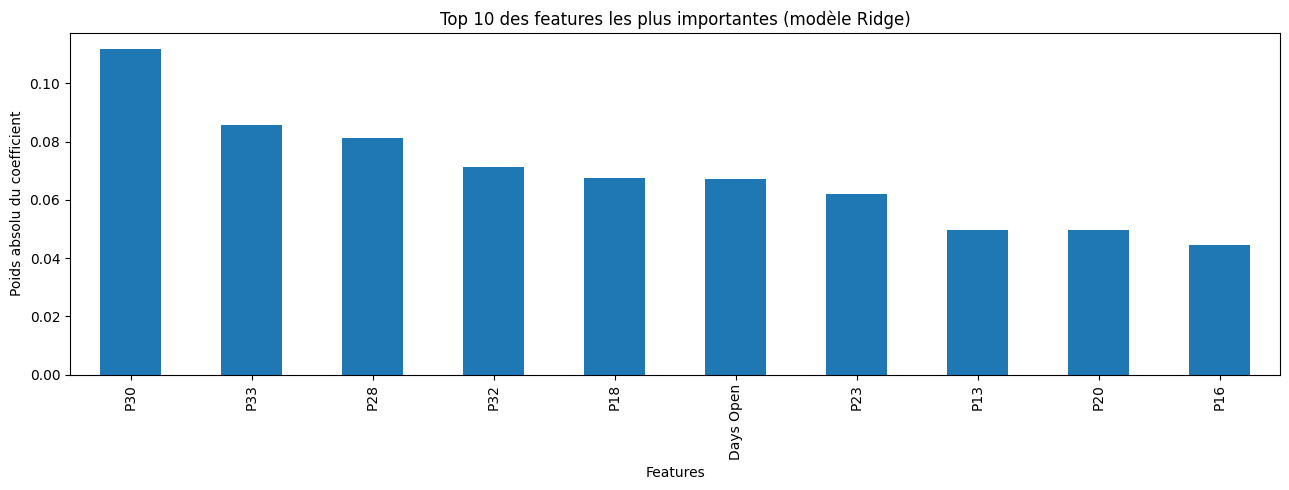

In [7]:
# Extraire le meilleur modèle Ridge depuis le pipeline
best_ridge_model = ridge_regressor.best_estimator_.named_steps['ridge']

# Récupérer les coefficients absolus
ridge_feature_coef = pd.Series(
    data=np.abs(best_ridge_model.coef_),
    index=X_train.columns
)

# Trier les coefficients par importance croissante
ridge_feature_coef = ridge_feature_coef.sort_values(ascending=False)

# Afficher les 10 features les plus importantes
plt.figure(figsize=(13, 5))
ridge_feature_coef.head(10).plot(kind='bar')
plt.title("Top 10 des features les plus importantes (modèle Ridge)")
plt.ylabel("Poids absolu du coefficient")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

In [8]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

params_lasso = {
    'lasso__alpha': [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'lasso__fit_intercept': [True, False]
}

lasso_regressor = GridSearchCV(lasso_pipeline, params_lasso, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
lasso_regressor.fit(X_train, y_train)

print(f'Optimal alpha: {lasso_regressor.best_params_["lasso__alpha"]:.2f}')
print(f'Optimal fit_intercept: {lasso_regressor.best_params_["lasso__fit_intercept"]}')
print(f'Best score: {lasso_regressor.best_score_:.4f}')


Optimal alpha: 0.10
Optimal fit_intercept: True
Best score: -0.4544


In [9]:
# Recréer le modèle avec les bons hyperparamètres
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(
        alpha=lasso_regressor.best_params_["lasso__alpha"],
        fit_intercept=lasso_regressor.best_params_["lasso__fit_intercept"]
    ))
])

# Fit & predict
lasso_model.fit(X_train, y_train)
y_train_pred = lasso_model.predict(X_train)
y_pred = lasso_model.predict(X_test)

# Scores
print('Train r2 score: ', r2_score(y_train, y_train_pred))
print('Test r2 score: ', r2_score(y_test, y_pred))

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.03210617615645239
Test r2 score:  0.0292064780236283
Train RMSE: 0.4498
Test RMSE: 0.5445


<Axes: >

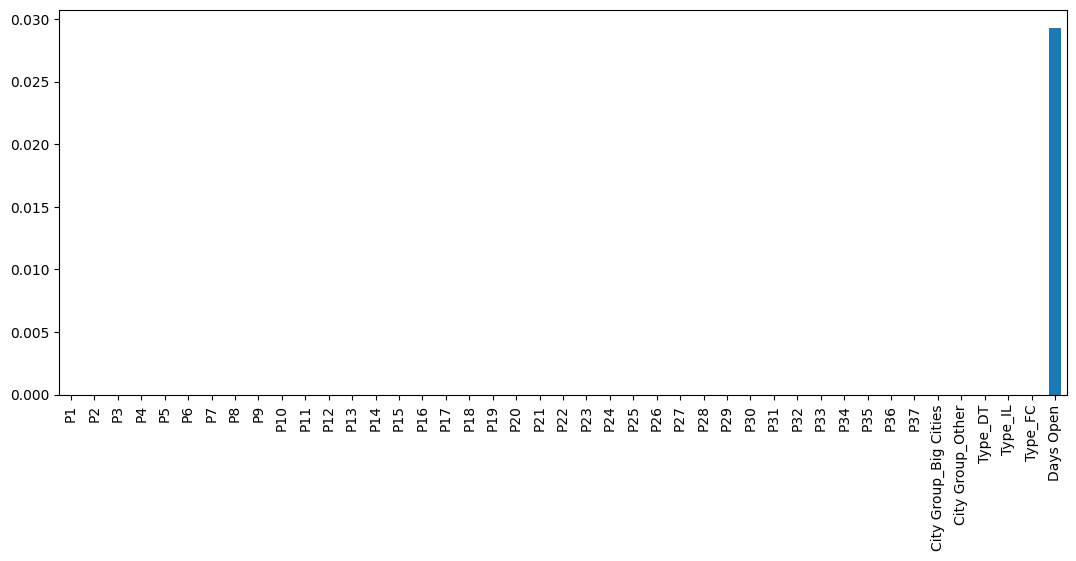

In [10]:
# Extraire le modèle Lasso depuis la pipeline
lasso = lasso_model.named_steps['lasso']

# Créer la série avec les coefficients absolus
lasso_feature_coef = pd.Series(
    index=X_train.columns,
    data=np.abs(lasso.coef_)
)

# Tracer le graphe
lasso_feature_coef.sort_values().plot(kind='bar', figsize=(13, 5))



## ElasticNet (combination of Ridge & Lasso)

In [11]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

# Use ElasticNetCV to tune alpha automatically instead of redundantly using ElasticNet and GridSearchCV
el_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=5e-2, cv=10, n_jobs=-1)         
el_model.fit(X_train, y_train)
print(f'Optimal alpha: {el_model.alpha_:.6f}')
print(f'Optimal l1_ratio: {el_model.l1_ratio_:.3f}')
print(f'Number of iterations {el_model.n_iter_}')

Optimal alpha: 0.622309
Optimal l1_ratio: 0.100
Number of iterations 34


In [12]:
y_train_pred = el_model.predict(X_train)
y_pred = el_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -9.79510928962582
Test r2 score:  0.055859274211956356
Train RMSE: 0.4128
Test RMSE: 0.5370


12 features with reduction of 72.09%


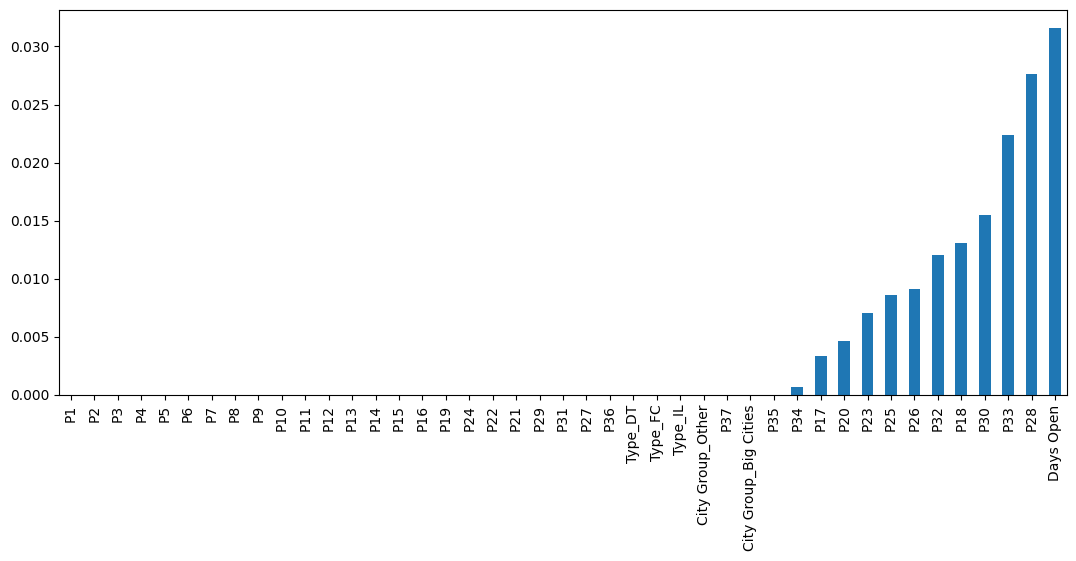

In [13]:
# ElasticNet Model Feature Importance
el_feature_coef = pd.Series(index = X_train.columns, data = np.abs(el_model.coef_))
n_features = (el_feature_coef>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(el_feature_coef))*100:2.2f}%')
el_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

## K-Nearest Neighbors

In [14]:
from sklearn.neighbors import KNeighborsRegressor

params_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
}

knn_model = KNeighborsRegressor()
knn_regressor = GridSearchCV(knn_model, params_knn, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
knn_regressor.fit(X_train, y_train)
print(f'Optimal neighbors: {knn_regressor.best_params_["n_neighbors"]}')
print(f'Best score: {knn_regressor.best_score_}')

Optimal neighbors: 11
Best score: -0.43011660772832555


In [15]:
knn_model = KNeighborsRegressor(n_neighbors=knn_regressor.best_params_["n_neighbors"])
knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_pred = knn_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -7.1881734316158745
Test r2 score:  0.14343057058949993
Train RMSE: 0.4071
Test RMSE: 0.5115


## Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

params_rf = {
    'max_depth': [10, 30, 35, 50, 65, 75, 100],
    'max_features': [.3, .4, .5, .6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [30, 50, 100, 200]
}

rf = RandomForestRegressor()
rf_regressor = GridSearchCV(rf, params_rf, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
rf_regressor.fit(X_train, y_train)
print(f'Optimal depth: {rf_regressor.best_params_["max_depth"]}')
print(f'Optimal max_features: {rf_regressor.best_params_["max_features"]}')
print(f'Optimal min_sample_leaf: {rf_regressor.best_params_["min_samples_leaf"]}')
print(f'Optimal min_samples_split: {rf_regressor.best_params_["min_samples_split"]}')
print(f'Optimal n_estimators: {rf_regressor.best_params_["n_estimators"]}')
print(f'Best score: {rf_regressor.best_score_}')

Optimal depth: 35
Optimal max_features: 0.5
Optimal min_sample_leaf: 4
Optimal min_samples_split: 10
Optimal n_estimators: 30
Best score: -0.4022455588362307


In [17]:
rf_model = RandomForestRegressor(max_depth=rf_regressor.best_params_["max_depth"], 
                                 max_features=rf_regressor.best_params_["max_features"], 
                                 min_samples_leaf=rf_regressor.best_params_["min_samples_leaf"], 
                                 min_samples_split=rf_regressor.best_params_["min_samples_split"], 
                                 n_estimators=rf_regressor.best_params_["n_estimators"], 
                                 n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -0.4745922452943405
Test r2 score:  0.22389160269763175
Train RMSE: 0.2809
Test RMSE: 0.4869


41 features with reduction of 4.65%


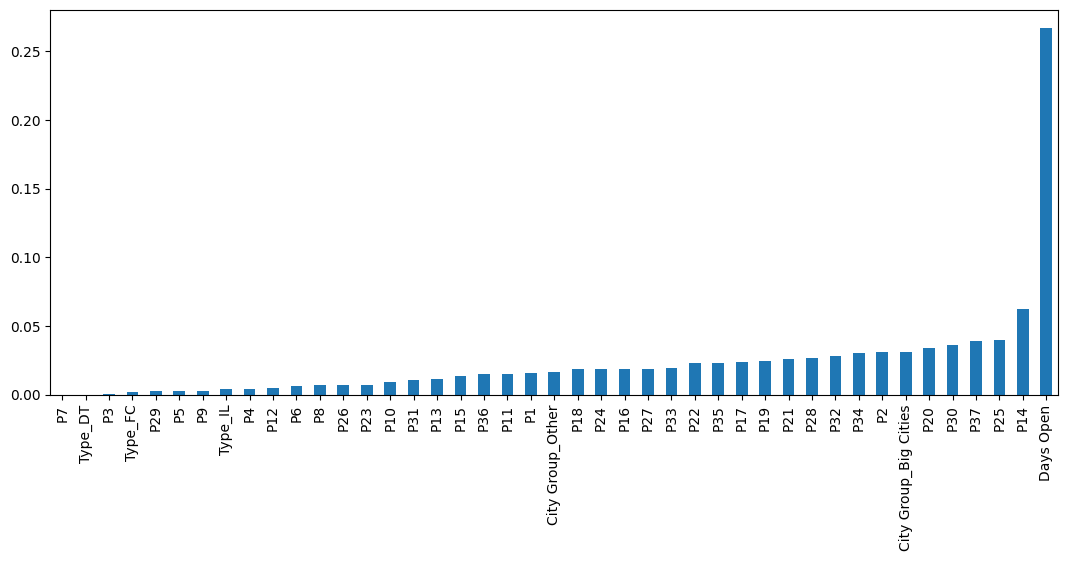

In [18]:
# Random Forest Model Feature Importance
rf_feature_importance = pd.Series(index = X_train.columns, data = np.abs(rf_model.feature_importances_))
n_features = (rf_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(rf_feature_importance))*100:2.2f}%')
rf_feature_importance.sort_values().plot(kind = 'bar', figsize = (13,5));

## Light GBM

In [19]:
import lightgbm as lgbm

params_lgbm = {
    'learning_rate': [.01, .1, .5, .7, .9, .95, .99, 1],
    'boosting': ['gbdt'],
    'metric': ['l1'],
    'feature_fraction': [.3, .4, .5, 1],
    'num_leaves': [20],
    'min_data': [10],
    'max_depth': [10],
    'n_estimators': [10, 30, 50, 100]
}

lgb = lgbm.LGBMRegressor()
lgb_regressor = GridSearchCV(lgb, params_lgbm, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
lgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {lgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal feature_fraction: {lgb_regressor.best_params_["feature_fraction"]}')
print(f'Optimal n_estimators: {lgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {lgb_regressor.best_score_}')

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

In [20]:
lgb_model = lgbm.LGBMRegressor(learning_rate=lgb_regressor.best_params_["learning_rate"], boosting='gbdt', 
                               metric='l1', feature_fraction=lgb_regressor.best_params_["feature_fraction"], 
                               num_leaves=20, min_data=10, max_depth=10, 
                               n_estimators=lgb_regressor.best_params_["n_estimators"], n_jobs=-1)
lgb_model.fit(X_train, y_train)
y_train_pred = lgb_model.predict(X_train)
y_pred = lgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

41 features with reduction of 4.65%


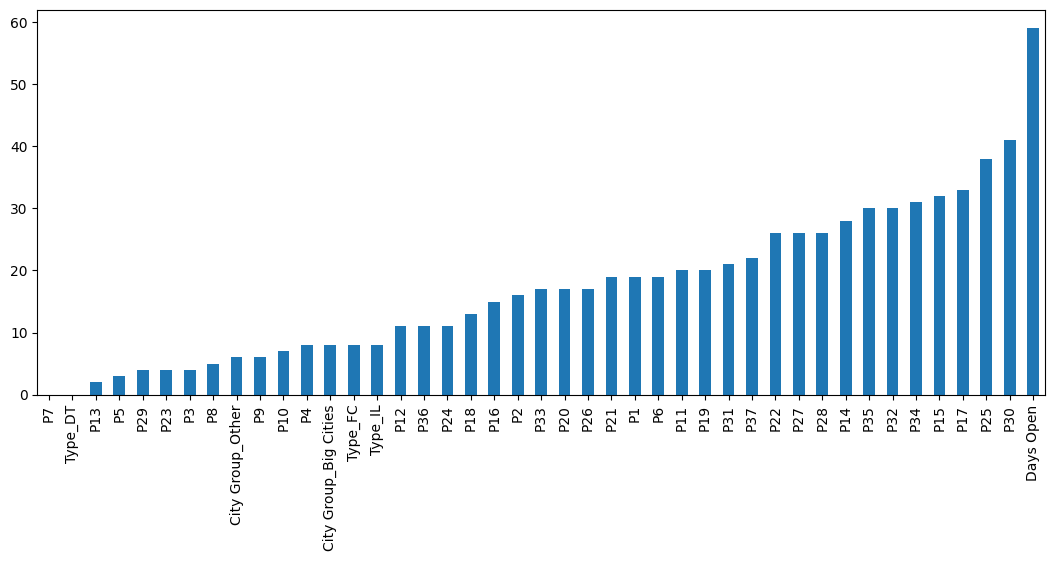

In [21]:
# LightGBM Feature Importance
lgb_feature_importance = pd.Series(index = X_train.columns, data = np.abs(lgb_model.feature_importances_))
n_features = (lgb_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(lgb_feature_importance))*100:2.2f}%')
lgb_feature_importance.sort_values().plot(kind = 'bar', figsize = (13,5));

## XGBoost

In [22]:
from xgboost import XGBRegressor, plot_importance
params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'max_depth': [4],
    'alpha': [3],
    'subsample': [.5],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor()
xgb_regressor = GridSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

Optimal lr: 0.1
Optimal colsample_bytree: 0.6
Optimal n_estimators: 100
Best score: -0.4126775757311286


In [23]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"], 
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"], 
                         max_depth=4, alpha=3, subsample=.5, 
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -0.9110144235776239
Test r2 score:  0.153976491988435
Train RMSE: 0.2903
Test RMSE: 0.5083


<Figure size 1300x600 with 0 Axes>

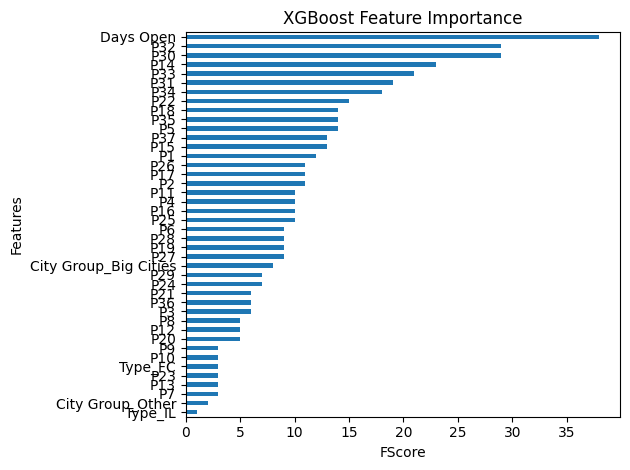

In [24]:
feature_important = xgb_model.get_booster().get_fscore()
data = pd.DataFrame.from_dict(feature_important, orient='index', columns=['score'])

if data.empty:
    print("Aucune feature importante n’a été extraite.")
else:
    data['score'] = data['score'].astype(float)
    data = data.sort_values(by='score', ascending=True)

    # Visualisation
    plt.figure(figsize=(13, 6))
    data.plot(kind='barh', legend=False)
    plt.title("XGBoost Feature Importance")
    plt.xlabel("FScore")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


## Regressor Ensembling

In [25]:
rf_model_en = RandomForestRegressor(max_depth=200, max_features=0.4, min_samples_leaf=3, 
                                 min_samples_split=6, n_estimators=30, n_jobs=-1, oob_score=True)
rf_model_en.fit(X_train, y_train)
y_train_pred = rf_model_en.predict(X_train)
y_pred = rf_model_en.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.2586505419620775
Test r2 score:  0.23690259795148183
Train RMSE: 0.2303
Test RMSE: 0.4828


ridge MAE: -0.461 (± 0.112)
lasso MAE: -0.423 (± 0.102)
rf_en MAE: -0.349 (± 0.075)
stacking MAE: -0.356 (± 0.078)


C:\Users\HP\AppData\Local\Temp\ipykernel_20004\4056186346.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, showmeans=True)


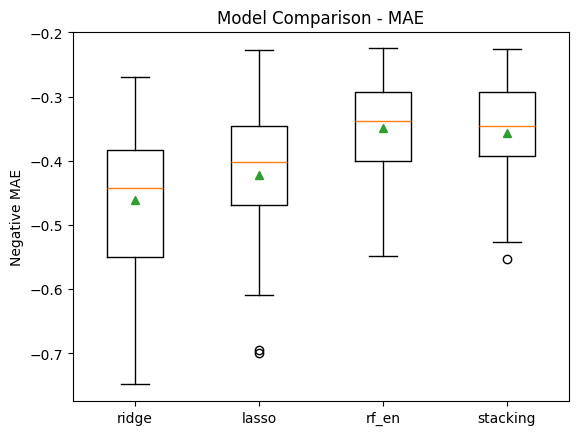

In [26]:
from numpy import mean, std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from matplotlib import pyplot as plt

# Define base models
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.01)
rf_model_en = RandomForestRegressor(n_estimators=100, random_state=42)

# Get a stacking ensemble of models
def get_stacking():
    base_models = list()
    base_models.append(('ridge', ridge_model))
    base_models.append(('lasso', lasso_model))
    base_models.append(('rf', rf_model_en))
    learner = LinearRegression()
    model = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
    return model

# Get a list of models to evaluate
def get_models():
    models = dict()
    models['ridge'] = ridge_model
    models['lasso'] = lasso_model
    models['rf_en'] = rf_model_en
    models['stacking'] = get_stacking()
    return models

# Evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=19)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# Evaluate the models and plot results
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'{name} MAE: {mean(scores):.3f} (± {std(scores):.3f})')

# Plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Comparison - MAE')
plt.ylabel('Negative MAE')
plt.show()
